In [2]:
!pip install nltk
!pip install keras
!pip install tensorflow
!pip install tensorflow_hub
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss


In [4]:
 # Load your dataset from the DataFrame
df = pd.read_csv('/workspaces/CONAN/Multitarget-CONAN/Multitarget-CONAN.csv')
df.head()

,INDEX,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION
0,0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",other,V1
1,1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,JEWS,V1
2,2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,MIGRANTS,V1
3,3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,JEWS,V1
4,4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,JEWS,V1


In [5]:
# Configure the TextVectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Fit the TextVectorization layer on 'hateSpeech'
vectorize_layer.adapt(df['HATE_SPEECH'])

# Create a label mapping for 'hsSubType'
label_mapping = {subtype: label for label, subtype in enumerate(df['TARGET'].unique())}
num_classes = len(label_mapping)
len(label_mapping)


8

In [6]:
batch_size = 16
# Define a function to vectorize the text and return the labels
def vectorize_text(text, label):
    #text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Map 'hsSubType' to integer labels
df['label'] = df['TARGET'].map(label_mapping)
# Split the data into training (80%) and the remaining (20%)
train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a TensorFlow dataset for training
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df['HATE_SPEECH'], train_df['label']))
train_ds = raw_train_ds.map(vectorize_text)
#train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Further split the remaining data into validation (10%) and test (10%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Create a TensorFlow dataset for validation
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df['HATE_SPEECH'], val_df['label']))
val_ds = raw_val_ds.map(vectorize_text)
#val_ds = raw_val_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create a TensorFlow dataset for testing
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df['HATE_SPEECH'], test_df['label']))
test_ds = raw_test_ds.map(vectorize_text)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#Check the dataset shapes: Print the shapes of the batches in train_ds and val_ds using a loop to ensure they match the expected shapes.
for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-12 22:43:44.897529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
#print the mapping
print(label_mapping)

{'other': 0, 'JEWS': 1, 'MIGRANTS': 2, 'WOMEN': 3, 'POC': 4, 'LGBT+': 5, 'MUSLIMS': 6, 'DISABLED': 7}


In [8]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
print('Number of classes: {}'.format(num_classes))

# Reverse the numerical mapping to get 'hsSubType' from label
reverse_mapping = {v: k for k, v in label_mapping.items()}
print("Label 0 corresponds to", reverse_mapping[0])
print("Label 1 corresponds to", reverse_mapping[1])

1287 --->  wont
 313 --->  coexist
Vocabulary size: 3829
Number of classes: 8
Label 0 corresponds to other
Label 1 corresponds to JEWS


<Axes: ylabel='label'>

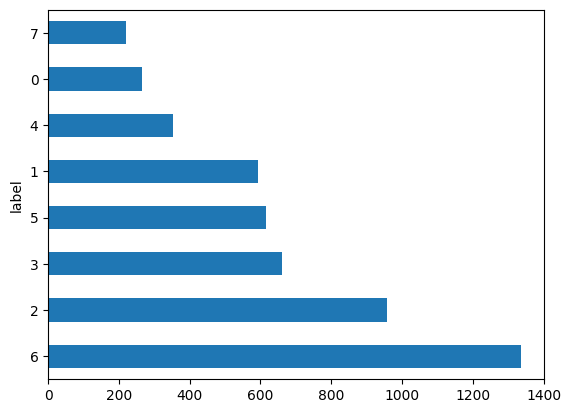

In [9]:
df['label'].value_counts().plot(kind='barh')

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-12 22:43:45.211344: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-10-12 22:43:45.211410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
# Imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


n_features = 250
epochs = 60
num_classes = 8

# Create the model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=n_features))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=['accuracy'])

# Fit data to the model
history = model.fit(train_ds,  # Use your training dataset
          validation_data=val_ds,  # Use your validation dataset
          epochs=epochs,  # Use the number of epochs you've defined
          verbose=1)

# Generate generalization metrics
score = model.evaluate(test_ds, verbose=0)  # Use your test dataset
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')



Epoch 1/60


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


251/251 [==============================] - 1s 2ms/step - loss: 12.1246 - accuracy: 0.1707 - val_loss: 2.7467 - val_accuracy: 0.1740
Epoch 2/60
251/251 [==============================] - 0s 1ms/step - loss: 2.2504 - accuracy: 0.1834 - val_loss: 2.1100 - val_accuracy: 0.1720
Epoch 3/60
251/251 [==============================] - 0s 1ms/step - loss: 2.0053 - accuracy: 0.2009 - val_loss: 2.0483 - val_accuracy: 0.2920
Epoch 4/60
251/251 [==============================] - 0s 2ms/step - loss: 1.9607 - accuracy: 0.2676 - val_loss: 2.0067 - val_accuracy: 0.2940
Epoch 5/60
251/251 [==============================] - 0s 1ms/step - loss: 1.9407 - accuracy: 0.2676 - val_loss: 1.9952 - val_accuracy: 0.2960
Epoch 6/60
251/251 [==============================] - 0s 1ms/step - loss: 1.9312 - accuracy: 0.2689 - val_loss: 1.9946 - val_accuracy: 0.2960
Epoch 7/60
251/251 [==============================] - 0s 1ms/step - loss: 1.9243 - accuracy: 0.2681 - val_loss: 2.0167 - val_accuracy: 0.2960
Epoch 8/60
251/2

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
history_dict = history.history
history_dict.keys()

32/32 [==============================] - 0s 1ms/step - loss: 1.8943 - accuracy: 0.3014
Loss:  1.894302248954773
Accuracy:  0.3013972043991089


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

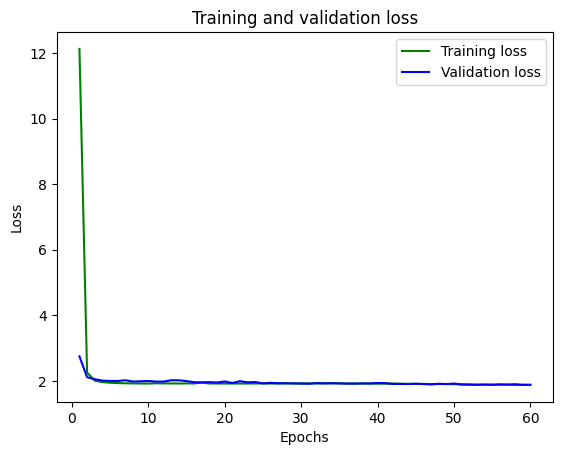

In [21]:
accuracy = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

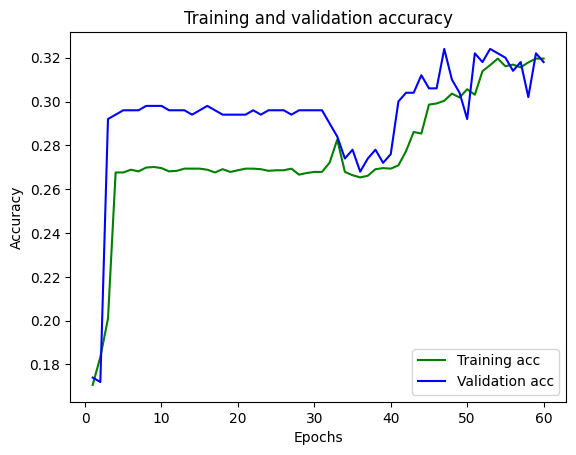

In [22]:
plt.plot(epochs, accuracy, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [23]:
# Save the model
model.save("my_trained_model_MULTITARGET_CONAN")


INFO:tensorflow:Assets written to: my_trained_model_MULTITARGET_CONAN/assets


INFO:tensorflow:Assets written to: my_trained_model_MULTITARGET_CONAN/assets


In [24]:
# Load the saved model
loaded_model = tf.keras.models.load_model("my_trained_model_MULTITARGET_CONAN")


In [32]:
input_sentence = "color"

# Vectorize the sentence
vectorized_sentence = vectorize_layer([input_sentence])

# Make predictions
predictions = loaded_model.predict(vectorized_sentence)
print(predictions)

predicted_class = np.argmax(predictions)
# Reverse the numerical mapping to get 'hsSubType' from label
reverse_mapping = {v: k for k, v in label_mapping.items()}
print("Predicted Class:", reverse_mapping[predicted_class])
print(label_mapping)

1/1 [==============================] - 0s 13ms/step


[[0.06080714 0.07655093 0.19474521 0.03877131 0.09285758 0.36922383
  0.08178307 0.08526094]]
Predicted Class: LGBT+
{'other': 0, 'JEWS': 1, 'MIGRANTS': 2, 'WOMEN': 3, 'POC': 4, 'LGBT+': 5, 'MUSLIMS': 6, 'DISABLED': 7}
